In [ ]:
from google.colab import drive
drive.mount('/content/drive')
root = '/content/drive/MyDrive/Colab/Project'

Este notebook levanta la carpeta data que se encuentra en el mismo directorio que el propio notebook y a partir de ella genera una csv y procesa los archivos de audio encontrados para generar espectrogramas de mell

In [1]:
import os
import torch
import torchaudio
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [65]:
%matplotlib qt5

In [2]:
#parametros para los calculos del mell
TARGET_SR = 16000  # Normalmente el audio se sule usar a 16k aunque encontre papers que trabajan a 22050 o a 22k (ver V2)
N_FFT = 512  #muestras de la fft
W_LEN = 400  # Numero de muestras para la ventan de la  fft (seg_de_ventan *sr) 
H_LEN = 160 # paso de la ventana entre una fft y la siguiente (paso * sr)
N_MELS = 26
N_MFCC = 13
#se suele usar una ventana de haning

#creo una bariable root la cual se puede cambiar si se quiere trabajar con otro directorio,
# pero a priori se deja en '.' para trabajar desde el directorio local del proyecto
root = '../data'
os.listdir(root)

['audio', 'MetaData.csv']

In [3]:
original = pd.read_csv(root+'/metaData.csv', index_col = "fileTrak")
original.head()

,MFI,artist,album,song,localPath,duracion
fileTrak,,,,,,
/audio/hombre/Imagine Dragons/Evolve/01 Next To Me.mp3,hombre,Imagine Dragons,Evolve,01 Next To Me,/audio/hombre/Imagine Dragons/Evolve,230.288889
/audio/hombre/Imagine Dragons/Evolve/02 I Don’t Know Why.mp3,hombre,Imagine Dragons,Evolve,02 I Don’t Know Why,/audio/hombre/Imagine Dragons/Evolve,190.120000
/audio/hombre/Imagine Dragons/Evolve/03 Whatever It Takes.mp3,hombre,Imagine Dragons,Evolve,03 Whatever It Takes,/audio/hombre/Imagine Dragons/Evolve,201.240000
/audio/hombre/Imagine Dragons/Evolve/04 Believer.mp3,hombre,Imagine Dragons,Evolve,04 Believer,/audio/hombre/Imagine Dragons/Evolve,204.346667
/audio/hombre/Imagine Dragons/Evolve/05 Walking The Wire.mp3,hombre,Imagine Dragons,Evolve,05 Walking The Wire,/audio/hombre/Imagine Dragons/Evolve,232.906667


In [69]:
#Eleccion del subset a usar

df = pd.concat([
    original[original.MFI == 'mujer'] 
])
#Elimino las canciones que duran menos de 10 segundos
drops = df[df.duracion <= 10]
if len(drops) != 0:
    df = df.drop(drops.index)

In [73]:
classes = list(np.unique(df.artist))
classes

['Ariana Grande', 'Katy Perry', 'Taylor Swift']

In [74]:
clas_dist = df.groupby(['artist'])['duracion'].sum()
clas_dist

artist
Ariana Grande    40151.390385
Katy Perry       55384.137809
Taylor Swift     46163.049569
Name: duracion, dtype: float64

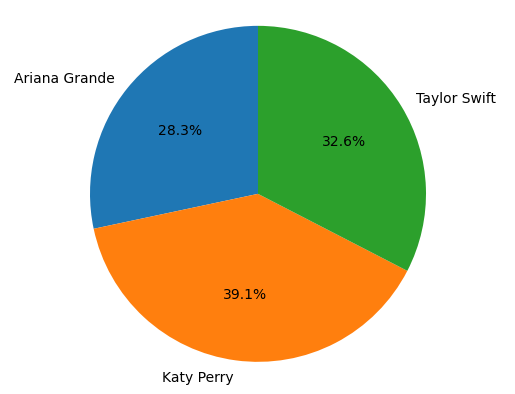

In [75]:
fig, ax = plt.subplots()
ax.pie(clas_dist, labels = clas_dist.index, autopct='%1.1f%%', shadow = False, startangle=90)
ax.axis('equal')
plt.show()


In [72]:
mel = []
mfcc = []
for c in tqdm(classes):
    file = df[df.artist == c].index[0]
    song, rate = torchaudio.load(root+file)
    song =  _stereo_to_mono(song)
    mel.append(MelCalculator(song))
    mfcc.append(MFCCCalculator(song))
    

100%|██████████| 3/3 [00:10<00:00,  3.61s/it]


In [76]:
i = 2
plot_spectrogram(mel[i], title = clas_dist.keys()[i])
plot_spectrogram(mfcc[i], title = clas_dist.keys()[i])


NameError: name 'plot_spectrogram' is not defined

In [37]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")

In [77]:
def _stereo_to_mono(signal , keepdim = False):
  """
  Colapsa todos los canales de la señal en no solo.
  """
  if(signal.shape[0] > 1):
    signal = torch.mean(signal, dim=0, keepdim= keepdim ) #, keepdim= True
  return signal

def _spliter(tensor, sr, time, truncar = True):
  """
  Recibe un tensor y un tiempo en segundos.
  Retorna el tensro original segmentado en muestras del tiempo recibido.
  En caso de que el recorte no sea exacto, se le agrega zero padding al final.
  """
  num_samples = int(sr * time)
  resto = len(tensor)%num_samples
  if truncar == True:
    splited = torch.split(tensor[:len(tensor) - resto], num_samples)
  else:
    padding = torch.zeros(num_samples - resto)
    splited = torch.split(torch.cat((tensor, padding)), num_samples)
  return splited

def _time_fixer(signal, sr, time):
  """
  Recibe una señal y un tiempo en segundos.
  En caso de que la señal dure menos de tiempo indicado se le agrega zero padding
  al final.
  En caso de que la señal dure mas de tiempo indicado se le recortan las ultimas muestras
  """
  if(signal.shape[0] < time*sr):
    padding = torch.zeros( time*sr - signal.shape[0])
    fixed_signal = torch.cat((signal, padding))
  elif(signal.shape[0] > time*sr):
    fixed_signal = signal[:time*sr]
  else:
    fixed_signal = signal
  return fixed_signal


def _preacondicionar_audio(signal, native_sr, target_sr, dur_sample = 10, dur_fix = 5*60):
  """
  Se genera un resample de la señal de audio, luego cambia el canal de audio a mono.
  Despues se generan muestras de la señal de audio de 10 segundos y finalmente se fixea la señal de audio a un tiempo de 5 minutos.
  """
  if( native_sr != target_sr):  #resample
    resampler = torchaudio.transforms.Resample(native_sr, target_sr)
    signal = resampler(signal)
  signal = _stereo_to_mono(signal)
  muestras = _spliter(signal, target_sr, dur_sample)
  fixed_signal = signal #fixed_signal = _time_fixer(signal, target_sr, dur_fix)
  return fixed_signal, muestras, target_sr

#signal, sr = torchaudio.load(fPath)
#signal, sr = _preacondicionar_audio(signal, sr, target_sr)
MelCalculator = torchaudio.transforms.MelSpectrogram(sample_rate=TARGET_SR,
                                                       n_fft = N_FFT,
                                                       hop_length = H_LEN,
                                                       win_length= W_LEN,
                                                       n_mels = N_MELS)

MFCCCalculator = torchaudio.transforms.MFCC(sample_rate = TARGET_SR,
                                            n_mfcc = int(N_MFCC),
                                            dct_type = 2,
                                            norm = 'ortho',
                                            log_mels = False,
                                            melkwargs = {"n_fft": N_FFT, "hop_length": H_LEN, "n_mels": N_MELS, "center": False},)


In [8]:
# M/F/I     indica si el artista es Male, Female, Instrumental
# artist    indica el nombre del artista o banda
# album
# song      indica el nombre de la cncion
# localPath indica la ruta de la carpeta donde esta contenida la cancion
# fileTrak  indica el nombre del archivo que contiene la pista de audio
# fileMel  indica el nombre del espectrograma de mel
# sample/full indica si el espectrograma es calculado respecto a toda la cancion o respecto a un sample de 10 seg
ndf = pd.DataFrame(columns=['MFI', 'artist', 'album', 'song', 'localPath', 'fileTrak', 'Mel26', 'MCC13', 'sample_full'])
ndf.set_index('fileTrak', inplace=True)


In [78]:
def save_transform(signal, transform, fName, foldName, FORCE = False, Full = False):
    if( not os.path.isdir(foldName)):
        os.mkdir(foldName)
    if((not os.path.isfile(fName)) or FORCE): #Calculo el mel si la cancion no esta previamente cargada o si se indico FORCE ## ERROR
        toSave = transform(signal)
        torch.save(toSave, fName)

In [79]:
melFolder = root + '/' + 'M26'
mfccFolder = root + '/' + 'MFCC13'
FORCE = False
data = []
errors = []
for f in tqdm(df.index):

    trakPath = root+ '/' + f
    try:
        #print('Loading:', trakPath)
        signal, sr = torchaudio.load(trakPath)
    except:
        errors.append(trakPath)
        #print('Error:', trakPath)
        continue
    
    signal, muestras, sr = _preacondicionar_audio(signal, sr, TARGET_SR)
    melIndex = 0

    fileMel = df.loc[f]['song'] + ' ' + str(melIndex) +'.pt' #
    melSave =  melFolder + '/' + fileMel #
    save_transform(signal, MelCalculator, melSave, melFolder, FORCE = FORCE, Full = True)

    fileMfcc = df.loc[f]['song'] + ' ' + str(melIndex) +'.pt' #
    mfccSave =  mfccFolder + '/' + fileMfcc #
    save_transform(signal, MFCCCalculator, mfccSave, mfccFolder, FORCE = FORCE, Full = True)

    data.append([df.loc[f]['MFI'],df.loc[f]['artist'] , df.loc[f]['album'], df.loc[f]['song'], df.loc[f]['duracion'], df.loc[f]['localPath'], f, melFolder, melSave, mfccFolder, mfccSave, 'full'])

    for sample in muestras: #podria tener que saltearme la muestra 0 porque suele no tener la voz del cantante
        melIndex += 1
        fileMel = df.loc[f]['song'] + ' ' + str(melIndex) +'.pt' #
        melSave =  melFolder + '/' + fileMel #
        save_transform(sample, MelCalculator, melSave, melFolder, FORCE = FORCE, Full = False)
        
        fileMfcc = df.loc[f]['song'] + ' ' + str(melIndex) +'.pt' #
        mfccSave =  mfccFolder + '/' + fileMfcc #
        save_transform(sample, MFCCCalculator, mfccSave, mfccFolder, FORCE = FORCE, Full = False)
        data.append([df.loc[f]['MFI'],df.loc[f]['artist'] , df.loc[f]['album'], df.loc[f]['song'], df.loc[f]['duracion'], df.loc[f]['localPath'], f, melFolder, melSave, mfccFolder, mfccSave, 'sample'])



100%|██████████| 642/642 [19:38<00:00,  1.84s/it]


In [80]:
ndf = pd.DataFrame(data, columns=['MFI', 'artist', 'album', 'song', 'duracion', 'localPath', 'fileTrak', 'melFolder', 'fileMel', 'mfccFolder', 'fileMfcc', 'sample_full'])
error_df = pd.DataFrame(errors, columns=['error_path'])
ndf.head()

,MFI,artist,album,song,duracion,localPath,fileTrak,melFolder,fileMel,mfccFolder,fileMfcc,sample_full
0,mujer,Ariana Grande,Brand New You (From 13),01. Brand New You (feat. Brynn Williams & Cait...,188.093333,/audio/mujer/Ariana Grande/Brand New You (From...,/audio/mujer/Ariana Grande/Brand New You (From...,../data/M26,../data/M26/01. Brand New You (feat. Brynn Wil...,../data/MFCC13,../data/MFCC13/01. Brand New You (feat. Brynn ...,full
1,mujer,Ariana Grande,Brand New You (From 13),01. Brand New You (feat. Brynn Williams & Cait...,188.093333,/audio/mujer/Ariana Grande/Brand New You (From...,/audio/mujer/Ariana Grande/Brand New You (From...,../data/M26,../data/M26/01. Brand New You (feat. Brynn Wil...,../data/MFCC13,../data/MFCC13/01. Brand New You (feat. Brynn ...,sample
2,mujer,Ariana Grande,Brand New You (From 13),01. Brand New You (feat. Brynn Williams & Cait...,188.093333,/audio/mujer/Ariana Grande/Brand New You (From...,/audio/mujer/Ariana Grande/Brand New You (From...,../data/M26,../data/M26/01. Brand New You (feat. Brynn Wil...,../data/MFCC13,../data/MFCC13/01. Brand New You (feat. Brynn ...,sample
3,mujer,Ariana Grande,Brand New You (From 13),01. Brand New You (feat. Brynn Williams & Cait...,188.093333,/audio/mujer/Ariana Grande/Brand New You (From...,/audio/mujer/Ariana Grande/Brand New You (From...,../data/M26,../data/M26/01. Brand New You (feat. Brynn Wil...,../data/MFCC13,../data/MFCC13/01. Brand New You (feat. Brynn ...,sample
4,mujer,Ariana Grande,Brand New You (From 13),01. Brand New You (feat. Brynn Williams & Cait...,188.093333,/audio/mujer/Ariana Grande/Brand New You (From...,/audio/mujer/Ariana Grande/Brand New You (From...,../data/M26,../data/M26/01. Brand New You (feat. Brynn Wil...,../data/MFCC13,../data/MFCC13/01. Brand New You (feat. Brynn ...,sample


In [81]:
for error in errors:
    print(error)

In [82]:
ndf.to_csv(f"{root}/woman.csv", index=False)
error_df.to_csv(f'{root}/errors.csv', index=False)

# Reconstructor

In [141]:
import numpy as np
import matplotlib.pyplot as plt
import librosa

In [ ]:
os.listdir(root + '/data')

In [ ]:
i_sample = 5
mel_recuperado = torch.load(root + df.at[i_sample, 'localPath'] + '/' + df.at[i_sample, 'fileMel'])
print(mel_recuperado.shape)

In [ ]:
plt.figure(figsize= (14, 5))
librosa.display.specshow(librosa.power_to_db(mel_recuperado), sr=target_sr, hop_length=512, x_axis='time', y_axis='mel')